In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [47]:
DATA_PATH = "../data/"
data = pd.read_csv(DATA_PATH+"2016_Building_Energy_Benchmarking.csv", sep=",", encoding="iso-8859-1")

In [48]:
pd.set_option('display.max_info_rows',50)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   OSEBuildingID                    int64  
 1   DataYear                         int64  
 2   BuildingType                     object 
 3   PrimaryPropertyType              object 
 4   PropertyName                     object 
 5   Address                          object 
 6   City                             object 
 7   State                            object 
 8   ZipCode                          float64
 9   TaxParcelIdentificationNumber    object 
 10  CouncilDistrictCode              int64  
 11  Neighborhood                     object 
 12  Latitude                         float64
 13  Longitude                        float64
 14  YearBuilt                        int64  
 15  NumberofBuildings                float64
 16  NumberofFloors                   int64  
 17  PropertyGFATot

In [49]:
data.isna().mean()[data.isna().mean() > 0.10]

SecondLargestPropertyUseType       0.502666
SecondLargestPropertyUseTypeGFA    0.502666
ThirdLargestPropertyUseType        0.823460
ThirdLargestPropertyUseTypeGFA     0.823460
YearsENERGYSTARCertified           0.964751
ENERGYSTARScore                    0.249704
Comments                           1.000000
Outlier                            0.990521
dtype: float64

In [50]:
label_1 = "TotalGHGEmissions"
label_2 = "SiteEnergyUse(kBtu)"

In [51]:
all_columns = list(data.columns)
categorical_columns = ["BuildingType", "PrimaryPropertyType","PropertyName","City","State","Address","City","State",
                       "ZipCode","CouncilDistrictCode","Neighborhood","ListOfAllPropertyUseTypes",
                       "LargestPropertyUseType","SecondLargestPropertyUseType","ThirdLargestPropertyUseType","ComplianceStatus"]
numerical_columns = [column for column in all_columns if column not in categorical_columns]

In [52]:
# Premier nettoyage du dataframe
def clean_data(df, to_drop):
    print("--------- shape before cleaning ---------")
    print(df.shape)
    df = df[df.ComplianceStatus == "Compliant"]
    df.Outlier.fillna('not_outlier', inplace=True)
    df.SecondLargestPropertyUseType.fillna('one_use', inplace=True)
    df.ThirdLargestPropertyUseType.fillna('one_use', inplace=True)
    df = df[df.NumberofBuildings != 0]
    df = df[df.NumberofFloors != 0]
    df = df[df['DefaultData'] == False]
    df.loc[df['SecondLargestPropertyUseType'] == 'one_use', 'SecondLargestPropertyUseTypeGFA'] = 0
    df.loc[df['ThirdLargestPropertyUseType'] == 'one_use', 'ThirdLargestPropertyUseTypeGFA'] = 0
    df['Nb_PropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].str.count(',') + 1
    df["Building_age"] = df["DataYear"] - df["YearBuilt"]
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna(df['PrimaryPropertyType'])
    df['LargestPropertyUseTypeGFA'] = df['LargestPropertyUseTypeGFA'].fillna(df['PropertyGFATotal'])
    df["%_LargestPropertyUseType"] = df["LargestPropertyUseTypeGFA"] / df["PropertyGFATotal"]    
    for col in to_drop:
        if col in df.columns:
            df = df.drop(columns=[col])
    print("--------- shape before cleaning ---------")
    print(df.shape)
    return df

# Mise à jour des listes des colonnes
def update_columns_list(list_1, dropped):
    new_list = [col for col in list_1 if col not in dropped]
    return new_list

In [53]:
# Vérifier la GFA
data["GFATotal"] = data["PropertyGFAParking"] + data["PropertyGFABuilding(s)"]
check_GPA = pd.Series(data["GFATotal"] == data["PropertyGFATotal"])
data.drop(columns=["GFATotal"], inplace=True)
check_GPA.value_counts()

True    3376
dtype: int64

In [54]:
data = data[~data.BuildingType.isin(["Multifamily LR (1-4)","Multifamily MR (5-9)","Multifamily HR (10+)"])]
data["%_GFAParking"] = data["PropertyGFAParking"] / data["PropertyGFATotal"]
data["%_GFABuilding"] = data["PropertyGFABuilding(s)"] / data["PropertyGFATotal"]


In [55]:
columns_to_drop = ["DataYear","PropertyName","Address","City","State",
                "Latitude","Longitude","YearBuilt","TaxParcelIdentificationNumber",
                "YearsENERGYSTARCertified","Comments","DefaultData","ComplianceStatus",
                "SiteEnergyUseWN(kBtu)","PropertyGFAParking","PropertyGFABuilding(s)","ListOfAllPropertyUseTypes"]

In [56]:
data = clean_data(data, columns_to_drop)
categorical_columns = update_columns_list(categorical_columns,columns_to_drop)

--------- shape before cleaning ---------
(1668, 48)
--------- shape before cleaning ---------
(1481, 34)


/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [57]:
data.BuildingType.value_counts()

NonResidential        1375
Nonresidential COS      73
Campus                  22
SPS-District K-12       10
Nonresidential WA        1
Name: BuildingType, dtype: int64

In [58]:
pd.set_option('display.max_columns',50)
data.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,%_GFAParking,%_GFABuilding,Nb_PropertyUseTypes,Building_age,%_LargestPropertyUseType
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,12,88434,Hotel,88434.0,one_use,0.0,one_use,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,not_outlier,249.98,2.83,0.000000,1.000000,1,89,1.000000
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,11,103566,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,not_outlier,295.86,2.86,0.145453,0.854547,3,20,0.809918
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,41,956110,Hotel,756493.0,one_use,0.0,one_use,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,not_outlier,2089.28,2.19,0.205748,0.794252,1,47,0.791220
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,10,61320,Hotel,61320.0,one_use,0.0,one_use,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,not_outlier,286.43,4.67,0.000000,1.000000,1,90,1.000000
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,1.0,18,175580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,not_outlier,505.01,2.88,0.353115,0.646885,3,36,0.703070


In [59]:
data.ENERGYSTARScore = data.ENERGYSTARScore.fillna('no_score')
data = data[data["ENERGYSTARScore"] != 'no_score']

In [60]:
features = ['BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'Neighborhood',  'Building_age','NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA',  '%_LargestPropertyUseType',
       'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)',
       'TotalGHGEmissions',
       '%_GFAParking', '%_GFABuilding','Nb_PropertyUseTypes']

In [61]:
categorical_columns = update_columns_list(categorical_columns,columns_to_drop)
numerical_columns = update_columns_list(numerical_columns,columns_to_drop)

In [62]:
df = data[features]
cat_features = [col for col in features if col in categorical_columns]
num_features = [col for col in features if col in categorical_columns]

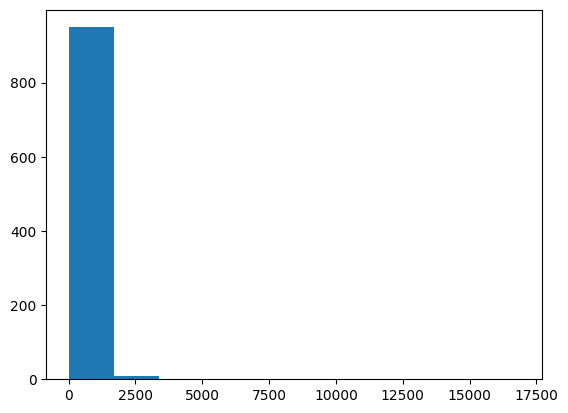

In [63]:
plt.hist(df["TotalGHGEmissions"]);

In [64]:
df["TotalGHGEmissions"].describe()

count      964.000000
mean       193.268672
std        873.974092
min         -0.800000
25%         20.165000
50%         49.215000
75%        140.090000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

In [65]:
df["TotalGHGEmissions"].quantile([0, .5, 0.98])

0.00      -0.8000
0.50      49.2150
0.98    1008.6684
Name: TotalGHGEmissions, dtype: float64

In [66]:
df = df[df["TotalGHGEmissions"] <= df["TotalGHGEmissions"].quantile([0.98])[0.98]]
df = df[df["TotalGHGEmissions"] > 0]

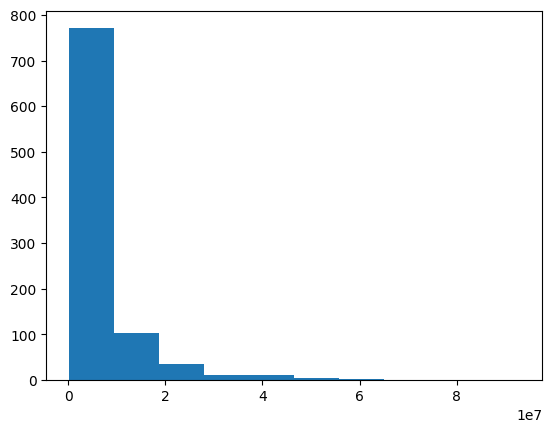

In [67]:
plt.hist(df[label_2]);

## Categorical features

In [68]:
df.BuildingType.nunique(), df.PrimaryPropertyType.nunique(), df.ZipCode.nunique(), df.Neighborhood.nunique(), df.LargestPropertyUseType.nunique()

(4, 16, 38, 18, 19)

In [69]:
X = df
y1 = df[[label_1]]
y2 = df[[label_2]]

X_enrg_train, X_enrg_test, y_enrg_train, y_enrg_test = train_test_split(df,y1,test_size=0.15, random_state=42)
X_enrg_train.shape, X_enrg_test.shape

# séparer la donnée pour avoir les 
X_ghe_train, X_ghe_test, y_ghe_train, y_ghe_test = train_test_split(df,y2,test_size=0.15, random_state=42)
X_ghe_train.shape, X_ghe_test.shape

((800, 20), (142, 20))

In [70]:
def pipe(df, means_zipcode=None, 
                means_neighborhood=None,
                means_ppropertype=None, 
                col_for_mean="PropertyGFATotal", 
                scaler=None,
                label_1=label_1,
                label_2=label_2):
    #### encoder la colonne ZipCode ###
    # encoding ZipCode with mean encoding and TotalGHGEmissions #
    # Calculer la moyenne de la colonne cible (label2) pour chaque code postal
    # Encoder la colonne code postal en fonction de la moyenne de la colonne cible
    # Supprimer la colonne originale
    if means_zipcode is None:
        means_zipcode = df.groupby('ZipCode')[col_for_mean].mean()
    df['Code_postal_encoded'] = df['ZipCode'].map(means_zipcode)
    df.drop(columns=['ZipCode'],inplace=True)
    
    #### encoder la colonne LargestPropertyUseType ###
    # Ajouter les colonnes encodées au dataframe d'origine
    # Supprimer la colonne originale
    onehot_encoded = pd.get_dummies(df['LargestPropertyUseType'], prefix='LargestPropertyUseType')
    df = pd.concat([df, onehot_encoded], axis=1)
    df.drop('LargestPropertyUseType', axis=1, inplace=True)
    
    #### encoder la colonne BuildingType ###
    # Ajouter les colonnes encodées au dataframe d'origine
    # Supprimer la colonne originale
    onehot_encoded_BuildingType = pd.get_dummies(df['BuildingType'], prefix='BuildingType')
    df = pd.concat([df, onehot_encoded_BuildingType], axis=1)
    df.drop('BuildingType', axis=1, inplace=True)    
    
    ### encoder la colonne Neighborhood ###
    # Calculer la moyenne de la colonne cible (label2) pour chaque quartier
    # Encoder la colonne quartier en fonction de la moyenne de la colonne cible
    # Supprimer la colonne originale
    if means_neighborhood is None:
        means_neighborhood = df.groupby('Neighborhood')[col_for_mean].mean()
    df['neighborhood_encoded'] = df['Neighborhood'].map(means_neighborhood)
    df.drop(columns=['Neighborhood'],inplace=True)
    
    ### encoder la colonne PrimaryPropertyType with mean encoding  ###
    # Calculer la moyenne de la colonne cible (label2) pour chaque PrimaryPropertyType
    # Encoder la colonne PrimaryPropertyType en fonction de la moyenne de la colonne cible
    # Supprimer la colonne catégorielle
    if means_ppropertype is None:
        means_ppropertype = df.groupby('PrimaryPropertyType')[col_for_mean].mean()
    df['PrimaryPropertyType_encoded'] = df['PrimaryPropertyType'].map(means_ppropertype)
    df.drop(columns=['PrimaryPropertyType'],inplace=True)
    
    ### Remplacer les valeurs 1/0 de LargestPropertyUseType_ par leur % de la surface totale
    # Liste des colonnes à remplacer
    # Boucle pour remplacer les valeurs dans chaque colonne
    cols_to_replace = list(df.filter(like="LargestPropertyUseType_").columns)
    for col in cols_to_replace:
        df[col] = df.apply(lambda row: row["%_LargestPropertyUseType"] if row[col] == 1 else 0, axis=1)    
    df.drop(columns=["%_LargestPropertyUseType"], inplace=True)
    
    #supprimer les labels du jeu de données
    df = df.drop(columns=[label_1,label_2])
    df.drop(columns=['SourceEUI(kBtu/sf)', 'SteamUse(kBtu)','Electricity(kBtu)', 'NaturalGas(kBtu)'], inplace=True)
    
    #scaler
    if scaler is None:
        scaler=StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    return df_scaled, means_zipcode, means_neighborhood, means_ppropertype, df.columns
    

In [71]:
scaler = StandardScaler()

X_enrg_train, means_zipcode_enrg, means_neighborhood_enrg, means_ppropertype_enrg, columns_enrg = pipe(X_enrg_train,scaler=scaler)
X_enrg_test, means_zipcode_enrg, means_neighborhood_enrg, means_ppropertype_enrg, a = pipe(X_enrg_test,
                                                                        means_zipcode=means_zipcode_enrg,
                                                                        means_neighborhood=means_neighborhood_enrg,
                                                                        means_ppropertype=means_ppropertype_enrg,
                                                                        col_for_mean=label_1,
                                                                        scaler=scaler)

In [72]:
X_ghe_train, means_zipcode_ghe, means_neighborhood_ghe, means_ppropertype_ghe, columns_ghe = pipe(X_ghe_train,scaler=scaler)
X_ghe_test, means_zipcode_ghe, means_neighborhood_ghe, means_ppropertype_ghe, b = pipe(X_ghe_test, means_zipcode=means_zipcode_ghe,
                                                                        means_neighborhood=means_neighborhood_ghe,
                                                                        means_ppropertype=means_ppropertype_ghe,
                                                                        col_for_mean=label_2,
                                                                        scaler=scaler)

## Modèles

In [73]:
def results_printed(model):
    # Best score                     
    print(f"Best score : {model.best_score_}")
    
    # Best Params
    print(f"Best params :\n {model.best_params_}")

## Label 1 : energy

In [74]:

dummy_regr = DummyRegressor()
parameters = {"strategy" : ("mean","median","quantile"),
            "quantile" : [0.25,0.5,0.75]}
grid_dummy = GridSearchCV(dummy_regr, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring="r2")
grid_dummy.fit(X_enrg_train, y_enrg_train)

GridSearchCV(cv=5, estimator=DummyRegressor(), n_jobs=-1,
             param_grid={'quantile': [0.25, 0.5, 0.75],
                         'strategy': ('mean', 'median', 'quantile')},
             scoring='r2')

In [75]:
results_printed(grid_dummy)

Best score : -0.0314658631981755
Best params :
 {'quantile': 0.25, 'strategy': 'mean'}


In [76]:
reg = LinearRegression()
parameters = {'fit_intercept': [True, False]}
grid_reg_lin = GridSearchCV(reg,
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring="r2")
grid_reg_lin.fit(X_enrg_train, y_enrg_train)

GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False]}, scoring='r2')

In [77]:
results_printed(grid_reg_lin)

Best score : -1591.1827893777938
Best params :
 {'fit_intercept': False}


In [78]:
lasso = Lasso()
alpha_space = np.logspace(-4, 2, 15)   # Checking for alpha from .0001 to 1 and finding the best value for alpha
parameters = {"alpha" : alpha_space}
grid_lasso = GridSearchCV(lasso, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring="r2")
grid_lasso.fit(X_enrg_train, y_enrg_train)

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.571e+04, tolerance: 1.545e+03
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.572e+04, tolerance: 1.545e+03
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 2.68269580e-04, 7.19685673e-04, 1.93069773e-03,
       5.17947468e-03, 1.38949549e-02, 3.72759372e-02, 1.00000000e-01,
       2.68269580e-01, 7.19685673e-01, 1.93069773e+00, 5.17947468e+00,
       1.38949549e+01, 3.72759372e+01, 1.00000000e+02])},
             scoring='r2')

In [79]:
results_printed(grid_lasso)

Best score : 0.4534239690708211
Best params :
 {'alpha': 1.9306977288832496}


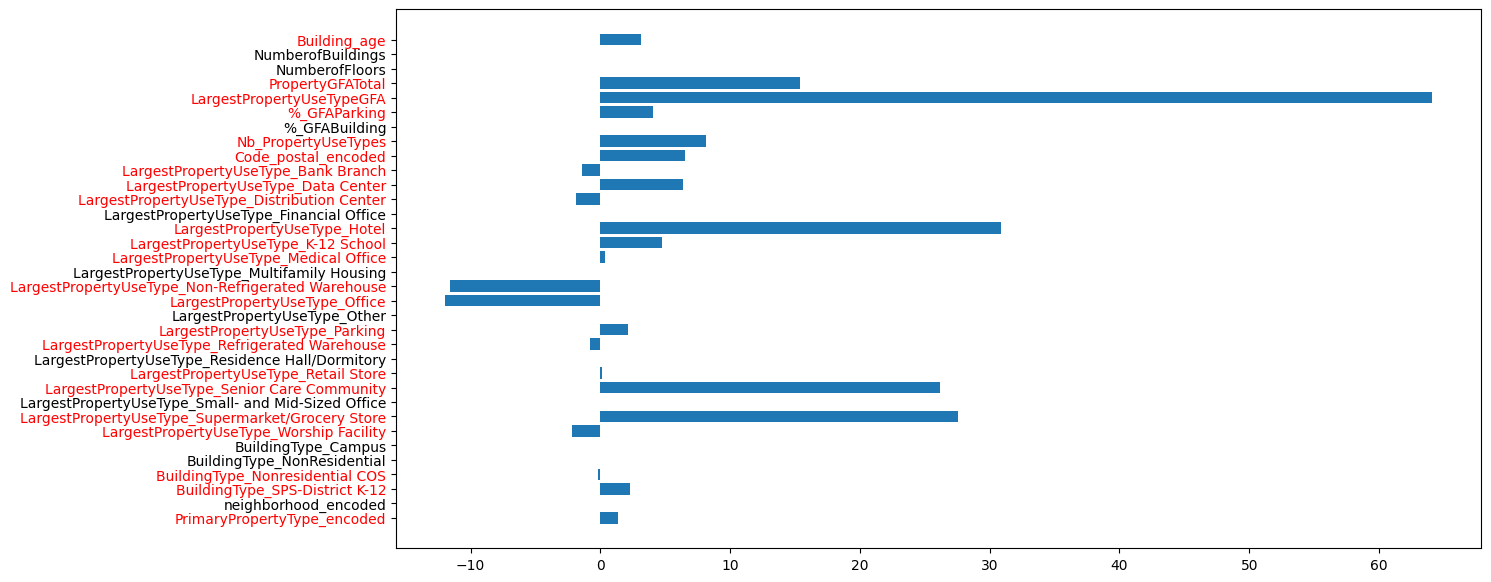

In [80]:
features_coef = pd.DataFrame(grid_lasso.best_estimator_.coef_.reshape(1,-1), columns=list(columns_enrg))
columns = list(reversed(features_coef.columns))
coef = list(reversed(grid_lasso.best_estimator_.coef_))

plt.figure(figsize=(14,7))
# Créer un graphique à barres horizontales
plt.barh(columns, coef)

# Récupérer les étiquettes de l'axe des abscisses
labels = plt.gca().get_yticklabels()

# Parcourir les étiquettes et appliquer un style différent aux étiquettes non nulles
for label, value in zip(labels, coef):
    if value != -0:
        label.set_color('red')  # Appliquer une couleur rouge aux étiquettes non nulles
    else:
        label.set_color('black')  # Appliquer une couleur noire aux étiquettes nulles

plt.show()

## Label 2 - GH2

In [81]:

dummy_regr = DummyRegressor()
parameters = {"strategy" : ("mean","median","quantile"),
            "quantile" : [0.25,0.5,0.75]}
grid_dummy = GridSearchCV(dummy_regr, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring="r2")
grid_dummy.fit(X_ghe_train, y_ghe_train)

GridSearchCV(cv=5, estimator=DummyRegressor(), n_jobs=-1,
             param_grid={'quantile': [0.25, 0.5, 0.75],
                         'strategy': ('mean', 'median', 'quantile')},
             scoring='r2')